## Implement of a curvature

Here we compute the transport map $\mathbf{O}_{ij}:= \mathscr{F}^T_{v \unlhd e}\mathscr{F}_{u \unlhd e}$ according to  https://arxiv.org/pdf/2206.08702.pdf and https://arxiv.org/pdf/1102.0075.pdf

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [2]:
#parameters 

n_samples = 5000
d = 2
ep = np.sqrt(n_samples ** ( - 2 / (d + 1)))
ep

0.05848035476425733

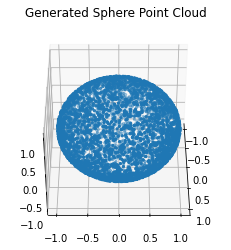

In [3]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.arccos(2 * np.random.uniform(0, 1, num_points) - 1)

    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    return np.column_stack((x, y, z))

# Generate a sphere point cloud with 1000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(40, 0)
plt.show()

In [4]:
d = 2
epsilon = 0.1
epsilon_sqrt = np.sqrt(epsilon)
epsilon_sqrt

0.31622776601683794

In [5]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:dim, :]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



In [52]:
def compute_curvature(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), 3, 3))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []
    
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            v_init = tau_neighbor[1] - tau_neighbor[0]
            v_fin = transport_maps[j, 0] @ transport_maps[i, j] @ transport_maps[0, i] @ v_init
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            tensor = (2 * np.pi - angle) / area
            
            tensor_av.append(tensor)
            
    tensor_av = np.sqrt(sum(tensor_av)/len(tensor_av) * 0.0001)
    
            
    return transport_maps, tensor_av
             

            
    
    

In [55]:
a, b = compute_curvature(sphere_cloud, np.expand_dims(sphere_cloud[2000], axis=0))
b

0.23575019423306312

In [56]:
# Choose the point for which you want to find k nearest neighbors
point_cloud = sphere_cloud
query_point_i = np.array([point_cloud[101]])

ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point_i)

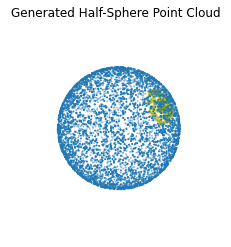

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax.scatter(query_point_i[:, 0], query_point_i[:, 1], query_point_i[:, 2], c = "r", s = 20)
ax.scatter(ep_neighbor[:, 0], ep_neighbor[:, 1], ep_neighbor[:, 2], c = "y", s = 10)
ax.set_title("Generated Half-Sphere Point Cloud")
ax.view_init(90, 0)
plt.axis('off')
plt.show()

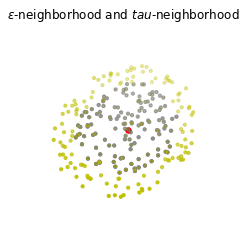

In [67]:
ind_farthest = len(tau_epsilon_neighbor) -1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tau_neighbor[:, 0], tau_neighbor[:, 1], tau_neighbor[:, 2], c = "y", s = 10)
ax.scatter(query_point_i[:, 0], query_point_i[:, 1], query_point_i[:, 2], c = "r", s = 30)
ax.scatter(ep_neighbor[:, 0], ep_neighbor[:, 1], ep_neighbor[:, 2], c = "b", s = 10)

ax.set_title("$\epsilon$-neighborhood and $tau$-neighborhood")
#ax.view_init(0, 0)
plt.axis('off')
plt.show()

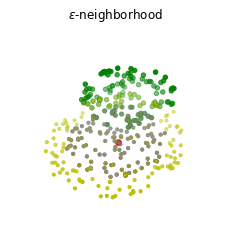

In [68]:
ind_farthest = len(tau_epsilon_neighbor) -1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tau_neighbor[:, 0], tau_neighbor[:, 1], tau_neighbor[:, 2], c = "y", s = 10)
ax.scatter(query_point_i[:, 0], query_point_i[:, 1], query_point_i[:, 2], c = "r", s = 30)
ax.scatter(tau_epsilon_neighbor[ind_farthest][:, 0], tau_epsilon_neighbor[ind_farthest][:, 1], tau_epsilon_neighbor[ind_farthest][:, 2], c = "g", s = 20)
ax.scatter(ep_neighbor[:, 0], ep_neighbor[:, 1], ep_neighbor[:, 2], c = "b", s = 10)

ax.set_title("$\epsilon$-neighborhood")
#ax.view_init(130, 40)
plt.axis('off')
plt.show()

In [23]:
for i in np.arange(1, 5):
    for j in np.arange(i + 1, 5):
        print((i,j))

(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)


In [24]:
O[0].T @ O[1]

array([[ 0.06969846, -0.63462063, -0.39355227],
       [ 0.58693004, -0.59759528,  0.26190097],
       [ 0.40787626,  0.23110235,  0.66898801]])

In [25]:
U, S, V = np.linalg.svd(O[0].T @ O[1], full_matrices = False)

In [26]:
U

array([[ 0.74368325, -0.09705577,  0.66144947],
       [ 0.31970394, -0.81730563, -0.47937553],
       [-0.58713253, -0.56797155,  0.5767874 ]])

In [27]:
V

array([[-3.18139626e-16, -7.98698002e-01, -6.01732085e-01],
       [-7.18127972e-01,  4.18752018e-01, -5.55822781e-01],
       [ 6.95911069e-01,  4.32120641e-01, -5.73567376e-01]])